**Environment Setup**

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import resnet101, ResNet101_Weights
from PIL import Image
from lightningmae.mae import MaskedAutoencoderLIT
from lightning import Trainer
from torchsummary import summary

**Hyperparamter setting**

In [2]:
BATCH_SIZE = 512
FEATURE_DIM = 800
NUM_EPOCHS = 20
TEMPERATURE = 0.2
LR = 5e-4

**Setting Device**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Transformer Construction**

In [4]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])


**Loading the dataset and performing transformation**

In [5]:
class AugmentedImageDataset(Dataset):
    def __init__(self, root, transform=None, for_training=False):
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if for_training:
            self.image_paths = self.image_paths[0:7000]
        else:
            self.image_paths = self.image_paths[7000:]
        self.transform = transform

    def __getitem__(self, index):
        path = self.image_paths[index]
        img = Image.open(path).convert("RGB")
        img1 = self.transform(img)
        img2 = self.transform(img)
        img3 = self.transform(img)
        return img1, img2, img3

    def __len__(self):
        return len(self.image_paths)

train_dataset = AugmentedImageDataset(root='./Data/synthetic_images/Images/', transform=transform, for_training=True)
val_dataset = AugmentedImageDataset(root='./Data/synthetic_images/Images/', transform=transform, for_training=False)
print(len(train_dataset))
print(len(val_dataset))

7000
1000


**Dataloader and setting batch size**

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

**Data Visualization**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7205882..2.2535014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7695861..1.3070468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5071026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2616663..0.94047624].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1760426..1.454815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851.

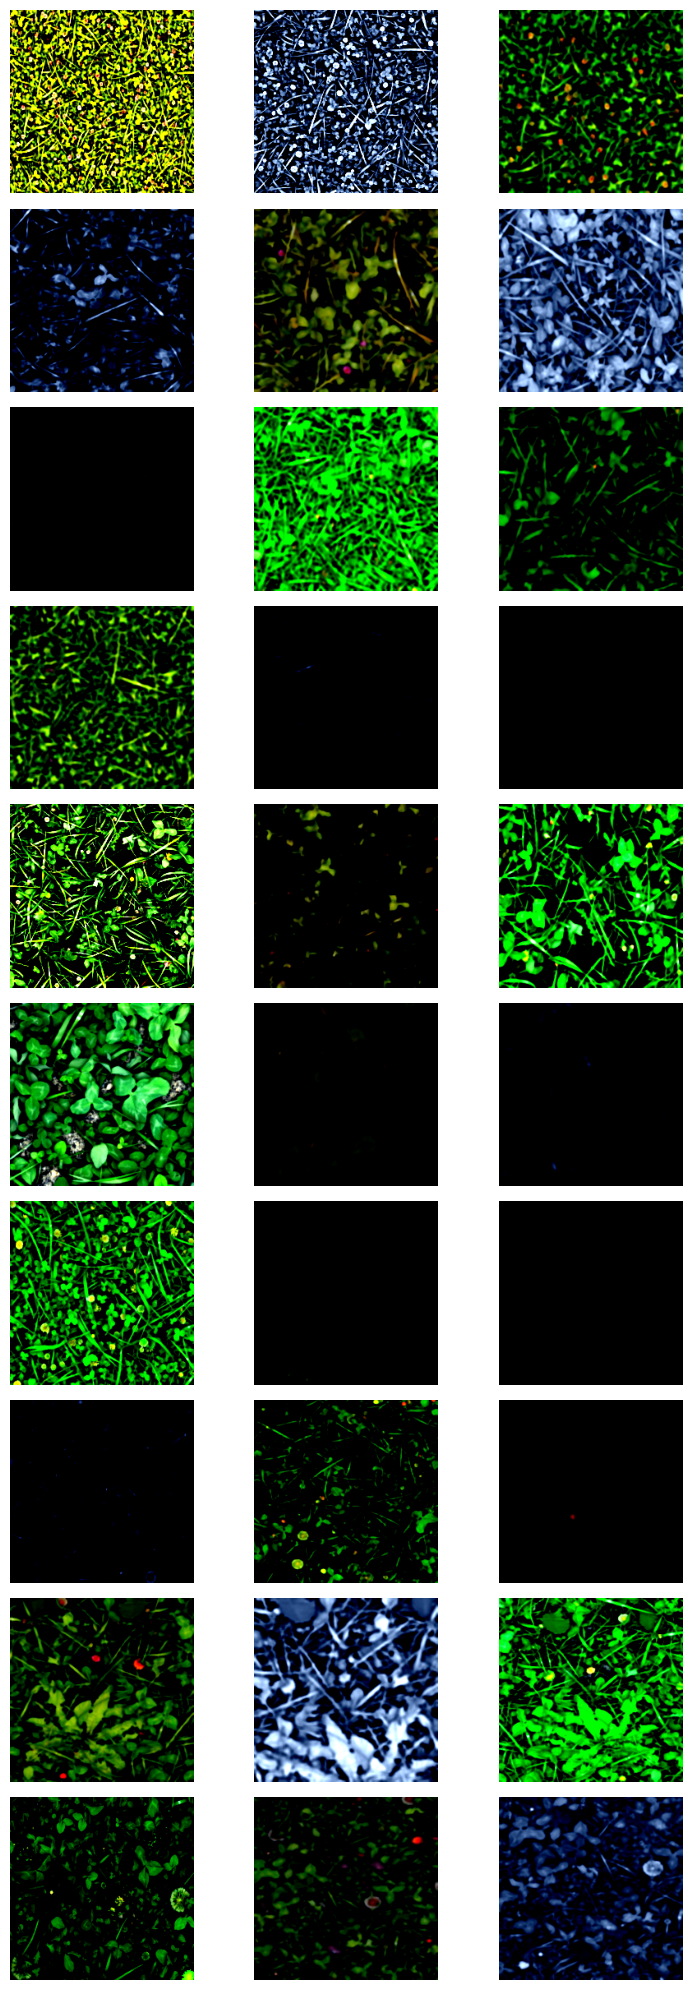

In [31]:
# Helper function to show a batch of images
def show_images(images):
    fig, axes = plt.subplots(len(images), len(images[0]), figsize=(8, 20))
    for i in range(len(images)):
        for j in range(len(images[0])):
            axes[i, j].imshow(np.clip(images[i][j].permute(1, 2, 0)))
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()


images = []
for i in range(10):
    images.append(train_dataset[i])

show_images(images)


In [7]:
class ResNetWithProjectionHead(nn.Module):
    def __init__(self, feature_dim=512, freeze_backbone=True, unfreeze_last_layers=3):
        super(ResNetWithProjectionHead, self).__init__()
        self.resnet = resnet101(weights=ResNet101_Weights.DEFAULT)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        if freeze_backbone:
            for param in self.resnet.parameters():
                param.requires_grad = False

        if unfreeze_last_layers > 0:
            layers_to_unfreeze = [self.resnet.layer4[-i] for i in range(1, unfreeze_last_layers + 1)]
            for layer in layers_to_unfreeze:
                for param in layer.parameters():
                    param.requires_grad = True

            # for param in self.resnet.layer3[-1].parameters():
            #     param.requires_grad = True

        self.projection_head = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, feature_dim)
        )

    def forward(self, x1, x2, x3):
        f1 = self.resnet(x1)
        f2 = self.resnet(x2)
        f3 = self.resnet(x3)

        e1 = self.projection_head(f1)
        e2 = self.projection_head(f2)
        e3 = self.projection_head(f3)

        e1 = nn.functional.normalize(e1, p=2, dim=1)
        e2 = nn.functional.normalize(e2, p=2, dim=1)
        e3 = nn.functional.normalize(e3, p=2, dim=1)
        return e1, e2, e3

In [8]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, z3):
        z1 = nn.functional.normalize(z1, dim=-1)
        z2 = nn.functional.normalize(z2, dim=-1)
        z3 = nn.functional.normalize(z3, dim=-1)

        sim_12 = torch.mm(z1, z2.T) / self.temperature
        sim_13 = torch.mm(z1, z3.T) / self.temperature
        sim_23 = torch.mm(z2, z3.T) / self.temperature

        labels = torch.arange(z1.size(0)).to(z1.device)

        loss_12 = nn.CrossEntropyLoss()(sim_12, labels)
        loss_13 = nn.CrossEntropyLoss()(sim_13, labels)
        loss_23 = nn.CrossEntropyLoss()(sim_23, labels)

        loss = (loss_12 + loss_13 + loss_23) / 3
        return loss

In [9]:
model = ResNetWithProjectionHead(feature_dim=FEATURE_DIM).to(device)
loss_fn = NTXentLoss(temperature=TEMPERATURE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
# summary(model, [(3, 224, 224), (3, 224, 224), (3, 224, 224)], device='cuda')

In [10]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    epoch_loss_train = 0.0
    epoch_loss_val = 0.0
    model.train()
    
    with tqdm(total=len(train_dataloader), desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]") as pbar:
        for (img1, img2, img3) in train_dataloader:
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
            optimizer.zero_grad()
            z1, z2, z3 = model(img1, img2, img3)
            loss = loss_fn(z1, z2, z3)
            
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()
            pbar.set_postfix({"Batch Loss Train": loss.item()})
            pbar.update(1)
            torch.cuda.empty_cache()

    model.eval()

    with tqdm(total=len(val_dataloader), desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]") as pbar:
        with torch.no_grad():
            for (img1, img2, img3) in val_dataloader:
                img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
                z1, z2, z3 = model(img1, img2, img3)
                loss = loss_fn(z1, z2, z3)
                epoch_loss_val += loss.item()
                pbar.set_postfix({"Batch Loss Val": loss.item()})
                pbar.update(1)
                torch.cuda.empty_cache()
    
    avg_train_loss = epoch_loss_train / len(train_dataloader)
    avg_val_loss = epoch_loss_val / len(val_dataloader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}")
    scheduler.step()

torch.save(model.state_dict(), "model.pth")
torch.save(losses, "losses.pth")

Epoch [1/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/20], Average Train Loss: 5.2670, Average Validation Loss: 4.5003


Epoch [2/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/20], Average Train Loss: 4.3114, Average Validation Loss: 3.9785


Epoch [3/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/20], Average Train Loss: 4.0021, Average Validation Loss: 3.8044


Epoch [4/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/20], Average Train Loss: 3.8350, Average Validation Loss: 3.6703


Epoch [5/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/20], Average Train Loss: 3.7211, Average Validation Loss: 3.5660


Epoch [6/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/20], Average Train Loss: 3.6255, Average Validation Loss: 3.4911


Epoch [7/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/20], Average Train Loss: 3.5399, Average Validation Loss: 3.3620


Epoch [8/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/20], Average Train Loss: 3.4745, Average Validation Loss: 3.3361


Epoch [9/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/20], Average Train Loss: 3.4208, Average Validation Loss: 3.2798


Epoch [10/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/20], Average Train Loss: 3.3847, Average Validation Loss: 3.2688


Epoch [11/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [11/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/20], Average Train Loss: 3.3394, Average Validation Loss: 3.2151


Epoch [12/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [12/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/20], Average Train Loss: 3.3223, Average Validation Loss: 3.2053


Epoch [13/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [13/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/20], Average Train Loss: 3.2948, Average Validation Loss: 3.2028


Epoch [14/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [14/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/20], Average Train Loss: 3.2814, Average Validation Loss: 3.1702


Epoch [15/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [15/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/20], Average Train Loss: 3.2644, Average Validation Loss: 3.1767


Epoch [16/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [16/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/20], Average Train Loss: 3.2397, Average Validation Loss: 3.1661


Epoch [17/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [17/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/20], Average Train Loss: 3.2429, Average Validation Loss: 3.1204


Epoch [18/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [18/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/20], Average Train Loss: 3.2288, Average Validation Loss: 3.1292


Epoch [19/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [19/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/20], Average Train Loss: 3.2213, Average Validation Loss: 3.1264


Epoch [20/20]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [20/20]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/20], Average Train Loss: 3.2247, Average Validation Loss: 3.1194


NameError: name 'losses' is not defined

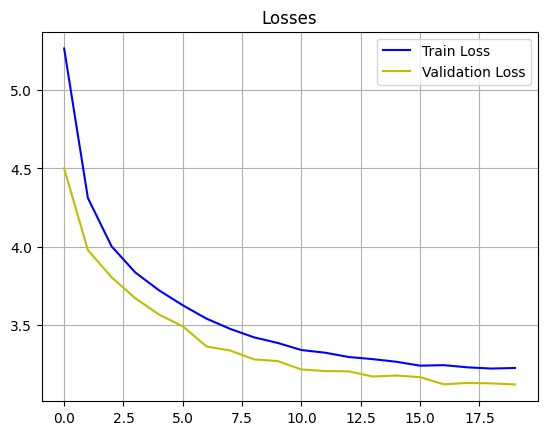

In [11]:
plt.title("Losses")
plt.plot(train_losses, label="Train Loss", color="b")
plt.plot(val_losses, label="Validation Loss", color="y")
plt.grid(True)
plt.legend()
plt.show()

In [136]:
def visualize_reconstruction(original, masked, reconstructed): 
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(original.permute(1, 2, 0).cpu().clamp(0, 1))
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Display masked image
    axes[1].imshow(masked.permute(1, 2, 0).cpu().clamp(0, 1))
    axes[1].set_title("Masked")
    axes[1].axis('off')
    
    # Display reconstructed image
    axes[2].imshow(reconstructed.permute(1, 2, 0).cpu().clamp(0, 1))
    axes[2].set_title("Reconstructed")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [124]:
MAE_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])
train_dataset2 = AugmentedImageDataset(root='./Data/synthetic_images/Images/', transform=MAE_transform)

In [125]:
train_data2 = DataLoader(train_dataset2, batch_size=7, shuffle=True, num_workers=0)

In [126]:
from pytorch_lightning.loggers import TensorBoardLogger

MAE = MaskedAutoencoderLIT(size='base', in_chans=3, base_lr=1e-3, betas=(b1, b2))
logger = TensorBoardLogger(save_dir='./logs')
trainer = Trainer(max_epochs=10, log_every_n_steps=1,logger=logger)
trainer.fit(MAE, train_data2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Asus\anaconda3\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Loading `train_dataloader` to estimate number of stepping batches.
C:\Users\Asus\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | MaskedAutoencoderViT | 111 M  | train
-------------------------------------------------------
111 M     Trainable params
252 K     Non-trainable params
111 M     Total params
447.631   Total estimated model params size 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [138]:
# Set up data iterator
data_iter_MAE2 = iter(train_data2)
img, _ = next(data_iter_MAE2)

# Move images to device if using GPU
img = img.to(device)

# Run inference
MAE.to(device)
MAE.eval()
with torch.no_grad():
    loss, predicted_image, mask = MAE(img)

In [139]:
pimg = MAE.model.patchify(img)

In [140]:
mpatches = pimg.clone()
mpatches[mask == 1] = 0

In [141]:
mimg = MAE.model.unpatchify(mpatches)

In [144]:
out = MAE.model.unpatchify(predicted_image)

torch.Size([7, 3, 224, 224])

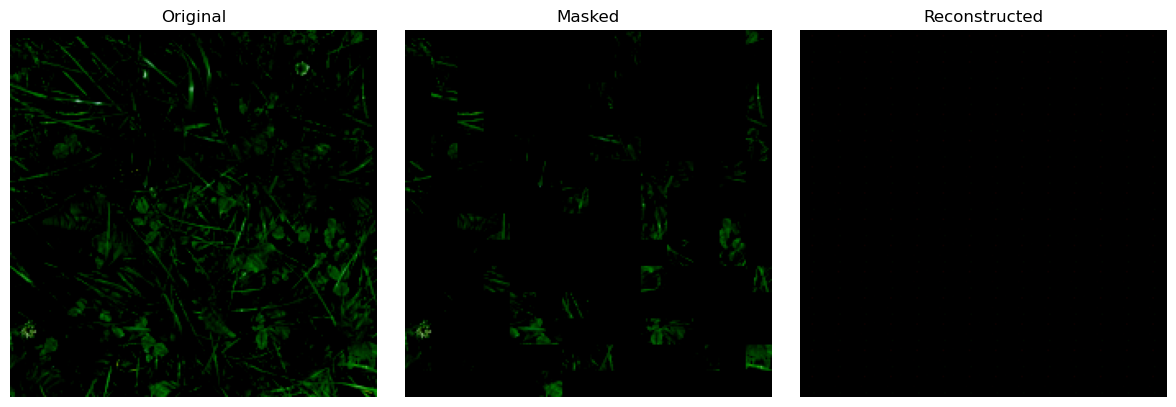

In [143]:
visualize_reconstruction(img[0], mimg[0], out[0])